In [77]:
from pathlib import Path
import pickle

import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia


In [78]:
plt.rcParams.update({"font.size": 14})

In [79]:
cwd = Path().cwd()

# Setting up the system

In [80]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.R, J_ground=2, F1=7 / 2, F=4
    )
]

polarizations = [[couplings.polarization_Z]]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
    ground_mains=[
        1
        * states.CoupledBasisState(
            J=2,
            F=3,
            F1=5 / 2,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=0,
            P=+1,
            electronic_state=states.ElectronicState.X,
        )
    ],
    excited_mains=[
        1
        * states.CoupledBasisState(
            J=3,
            F=4,
            F1=7 / 2,
            mF=-1,
            I1=1 / 2,
            I2=1 / 2,
            Ω=1,
            P=-1,
            electronic_state=states.ElectronicState.B,
        )
    ],
)

In [405]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)

odepars = lindblad_julia.odeParameters(
    # Ω0="phase_modulation(t, β, ωphase)*rabi_from_intensity(gaussian_2d_rotated(vz*t, y0+vy*t, peak_intensity, laser_center_z, laser_center_y, σz, σy, θ), main_coupling)",
    Ω0="rabi_from_intensity(gaussian_2d_rotated(vz*t, y0+vy*t, peak_intensity, laser_center_z, laser_center_y, σz, σy, θ), main_coupling)",
    peak_intensity=1000.0,
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    # laser phase modulation
    ωphase=hamiltonian.Γ,  # laser phase modulation frequency [rad/s]
    β=0,  # laser phase modulation depth [rad]
    PZ0=1,
    # molecules
    z0=0,  # molecule start z position [m]
    vz=184,  # longitudinal molecular velocity [m/s]
    vx=0,
    y0=0.0,
    vy=0.0,
    σz=4.53e-4,
    σy=1.04e-3,
    θ=0,
    laser_center_z=0,
    laser_center_y=0,
    main_coupling=0.5,
)


In [473]:
%%time
obe_system_original = lindblad.setup_OBE_system_transitions(
    trans, transition_selectors, verbose=True, qn_compact=True, decay_channels=None
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


CPU times: total: 9.61 s
Wall time: 53.7 s


In [83]:
[QN.largest for QN in obe_system_original.QN]

[|X, J = 2, F₁ = 3/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 2, mF = -2, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 3/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 2, mF = -2, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>,
 |X, J = 2, F₁ = 5/2, F = 3, mF = -3, I₁ = 1/2, I₂ = 1/2, P

In [84]:
obe_system_original.H_symbolic

Matrix([
[-251619072761.693,                 0,                 0,                0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,                         0,                         0,           0,                          0,                           0,                         0,                         0,                0,                0,                        0,                        0,          0,                          0,                         0,                        0,                        0,                 0],
[                0, -251619072761.593,                 0,                0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,                         0,                         0,           0,                          

In [477]:
from copy import deepcopy

obe_system_python = deepcopy(obe_system_original)

In [478]:
obe_system = lindblad_julia.setup_OBE_system_julia(
    obe_system_python, transition_selectors, odepars
)

In [479]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 3, F₁ = 7/2, F = 4>"
states,
"|X, J = 2>",0.530151
"|X, J = 4>",0.469849


## Detection Laser Beam Profile

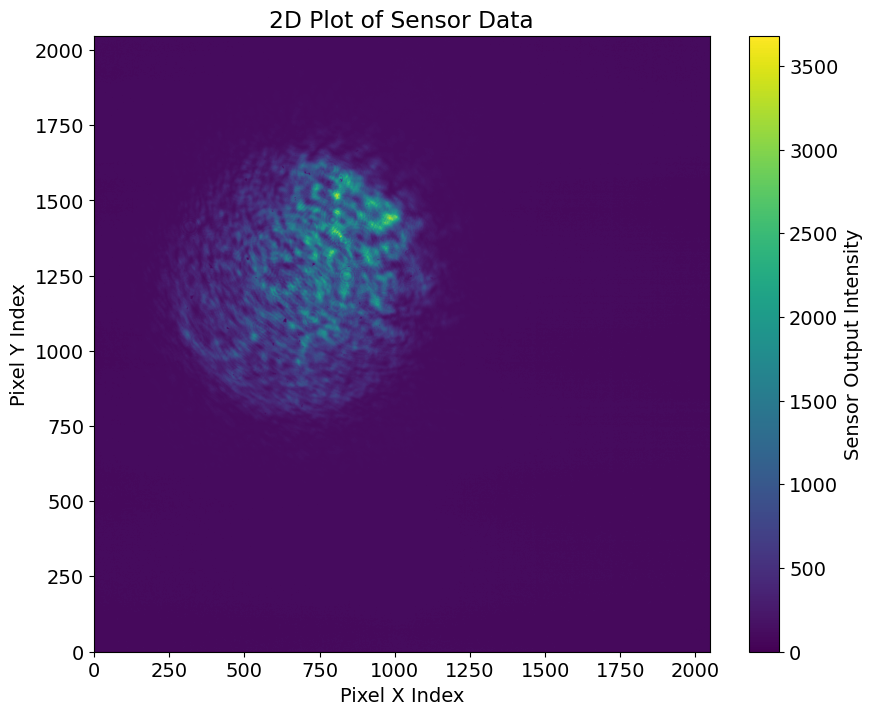

In [163]:
# Reading the file and extracting the data lines, skipping headers
file_path = "beam-profile.txt"
with open(file_path, 'r') as file:
    lines = file.readlines()

# Removing any leading/trailing whitespace and filtering lines with valid data
sensor_data = [line.strip() for line in lines]
sensor_data_clean = [line for line in sensor_data if line and (line[0].isdigit() or line[0] == ';')]

# Converting the cleaned list of semicolon-separated strings into a 2D list of integers
sensor_matrix_clean = []
for line in sensor_data_clean:
    try:
        # Convert each line to integers, skipping empty or non-numeric entries
        sensor_matrix_clean.append([int(value) for value in line.split(';') if value.strip().isdigit()])
    except ValueError:
        continue  # Skip lines that cause errors during conversion

# Convert the cleaned sensor matrix into a NumPy 2D array
sensor_array = np.array(sensor_matrix_clean)

# Plotting the 2D sensor data using a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(sensor_array, cmap='viridis', origin='lower')
plt.colorbar(label='Sensor Output Intensity')
plt.title('2D Plot of Sensor Data')
plt.xlabel('Pixel X Index')
plt.ylabel('Pixel Y Index')
plt.show()

### Read data from thorlabs beam profiler


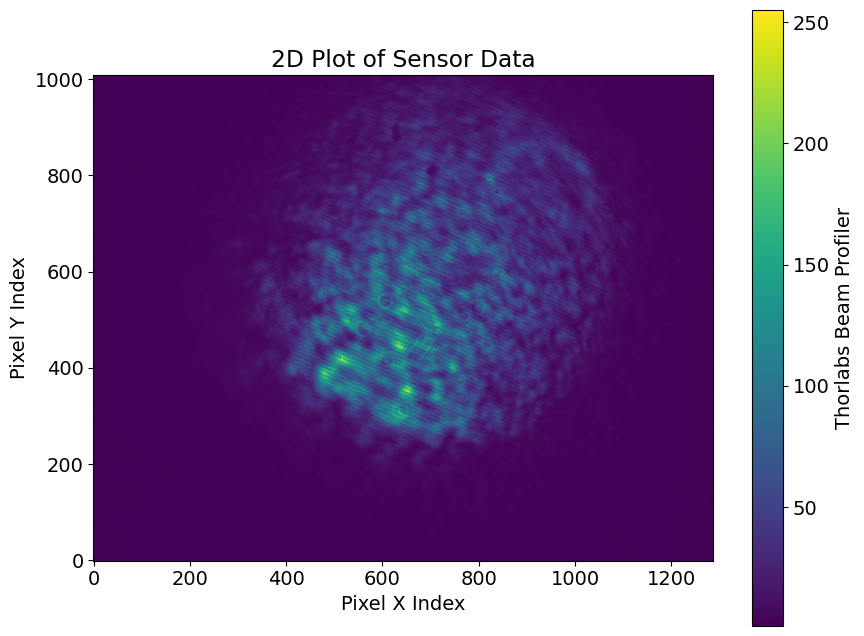

In [346]:
from PIL import Image
file_path = "beam_profile/DeviceData_#001.png"
# Open the image file
image = Image.open(file_path)

# Convert the image to grayscale (optional, if you need a 2D array)
image = image.convert('L')
# Convert the image to a NumPy array
image_array = np.array(image)
image_array = image_array[::-1, :]

# Plotting the 2D sensor data using a heatmap
plt.figure(figsize=(10, 8))
plt.imshow(image_array, cmap='viridis', origin='lower')
plt.colorbar(label='Thorlabs Beam Profiler')
plt.title('2D Plot of Sensor Data')
plt.xlabel('Pixel X Index')
plt.ylabel('Pixel Y Index')
plt.show()

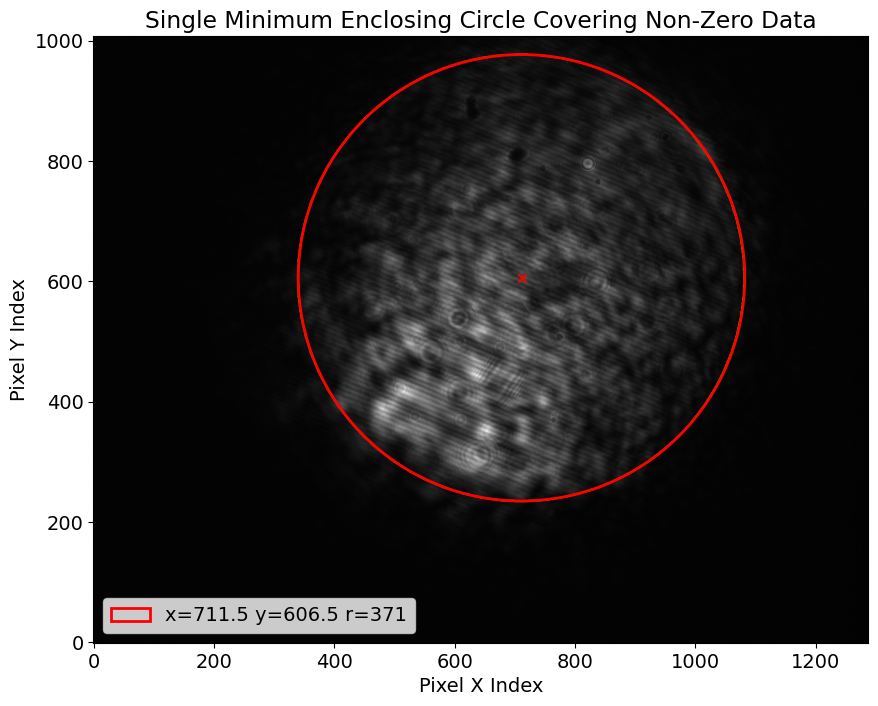

In [235]:
import cv2
import numpy as np
from scipy.optimize import curve_fit
sensor_array = image_array
# Converting the array to uint8 format needed for OpenCV
image = (sensor_array).astype(np.uint8)

# Apply thresholding to create a binary mask of the non-zero data
_, thresholded = cv2.threshold(image, 60, 255, cv2.THRESH_BINARY)

# Find contours of the thresholded image to locate the non-zero areas
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Combine all contours into one to get a single enclosing circle
all_points = np.vstack(contours)

# Find the minimum enclosing circle that covers all combined contours
(x, y), radius = cv2.minEnclosingCircle(all_points)
center = (int(x), int(y))
radius = int(radius)

# Draw the enclosing circle on the original image
output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convert to BGR for colored circle visualization
cv2.circle(output_image, center, radius, (0, 255, 0), 2)

# Display the image with the single enclosing circle using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(output_image, cmap='gray', origin='lower')
plt.scatter(center[0], center[1], color='red', marker='x')  # Mark the center point
# Draw the circle using matplotlib's Circle object for clear visualization
circle = plt.Circle(center, radius, color='red', fill=False, linewidth=2, label=f'x={x} y={y} r={radius}')
plt.gca().add_patch(circle)
plt.legend()
plt.xlabel(f"Center: {center}, Radius: {radius}")
plt.title("Single Minimum Enclosing Circle Covering Non-Zero Data")
plt.xlabel('Pixel X Index')
plt.ylabel('Pixel Y Index')
plt.show()



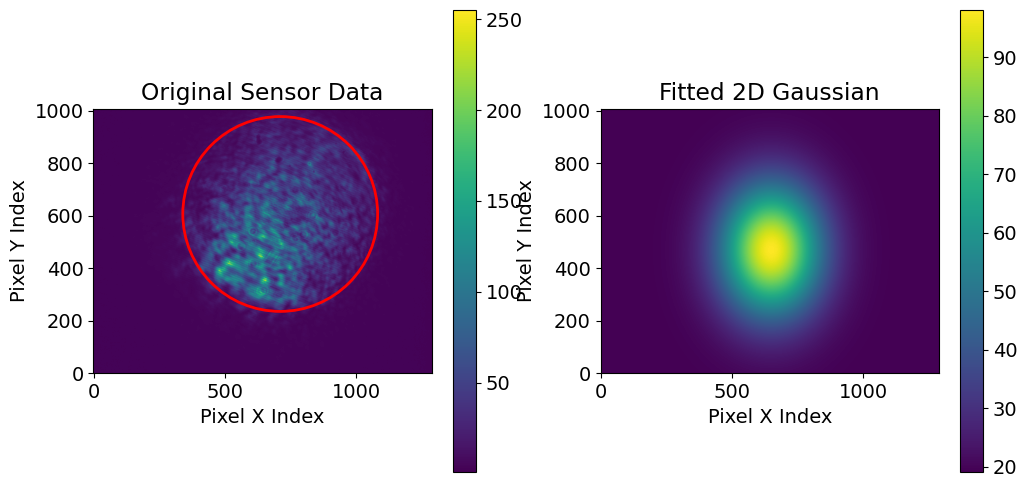

In [236]:
from scipy.optimize import curve_fit

# Define a 2D Gaussian function
def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    g = offset + amplitude * np.exp(-(((x - xo) ** 2) / (2 * sigma_x ** 2) + ((y - yo) ** 2) / (2 * sigma_y ** 2)))
    return g.ravel()

# Generate a grid of x, y coordinates
x = np.arange(sensor_array.shape[1])
y = np.arange(sensor_array.shape[0])
x, y = np.meshgrid(x, y)

# Create a mask to select data within the circle
mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2

# Apply the mask to extract the relevant data
x_data = x[mask]
y_data = y[mask]
z_data = sensor_array[mask]

# Initial guesses for the Gaussian parameters: amplitude, xo, yo, sigma_x, sigma_y, offset
initial_guess = (z_data.max(), center[0], center[1], radius / 2, radius / 2, z_data.min())

# Fit the Gaussian model to the data
popt, _ = curve_fit(gaussian_2d, (x_data, y_data), z_data, p0=initial_guess)

# Extract the fitted parameters
amplitude, xo, yo, sigma_x, sigma_y, offset = popt

# Generate fitted data for visualization
z_fitted = gaussian_2d((x, y), *popt).reshape(sensor_array.shape)

# Plot the original data and the fitted Gaussian
plt.figure(figsize=(12, 6))

# Plot original data
plt.subplot(1, 2, 1)
plt.imshow(sensor_array, cmap='viridis', origin='lower')
plt.title('Original Sensor Data')
circle = plt.Circle(center, radius, color='red', fill=False, linewidth=2, label=f'x={x} y={y} r={radius}')
plt.gca().add_patch(circle)
plt.xlabel('Pixel X Index')
plt.ylabel('Pixel Y Index')
plt.colorbar()

# Plot fitted Gaussian
plt.subplot(1, 2, 2)
plt.imshow(z_fitted, cmap='viridis', origin='lower')
plt.title('Fitted 2D Gaussian')
plt.xlabel('Pixel X Index')
plt.ylabel('Pixel Y Index')
plt.colorbar()

plt.show()

## Smooth Image

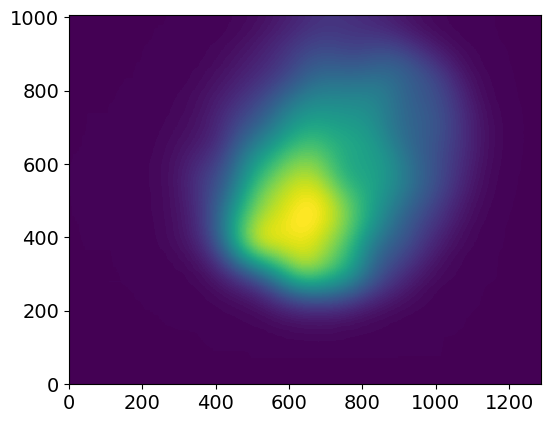

In [347]:
import scipy.ndimage as ndimage
img = ndimage.gaussian_filter(sensor_array, sigma=(50, 50), order=0)
plt.imshow(img, interpolation='nearest', origin='lower')
plt.show()

In [510]:
sensor_array.shape

(1008, 1288)

In [511]:
pixel_x_size, pixel_y_size = 8.77e-3/1360, 6.6e-3/1024


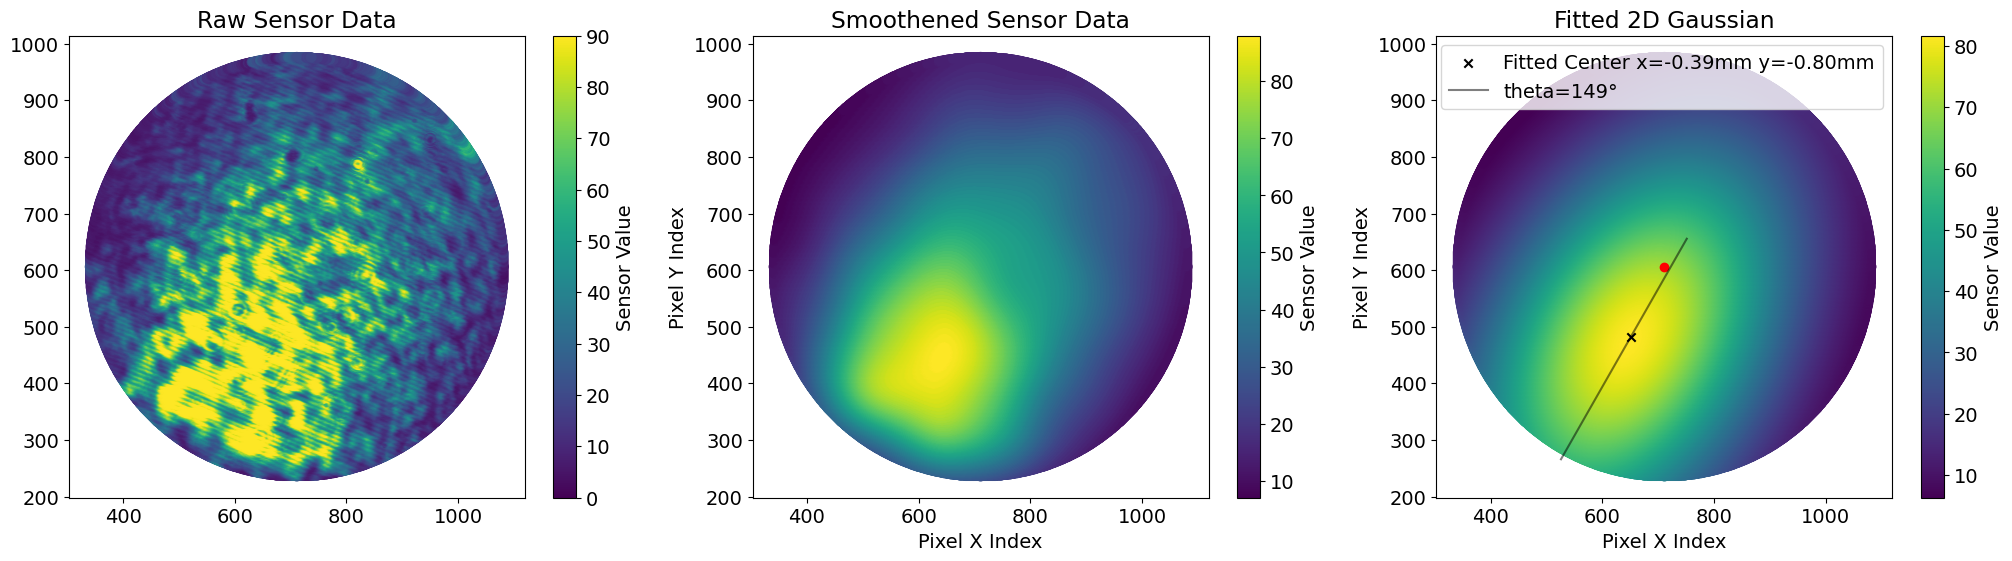

In [529]:
from scipy.optimize import curve_fit

# Define a 2D Gaussian function
def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    g = amplitude * np.exp(-(((x - xo) ** 2) / (2 * sigma_x ** 2) + ((y - yo) ** 2) / (2 * sigma_y ** 2)))
    return g.ravel()

# Define the 2D Gaussian function with rotation
def gaussian_2d_rotated(coords, A, x0, y0, sigma_x, sigma_y, theta):
    x, y = coords
    a = np.cos(theta)**2 / (2*sigma_x**2) + np.sin(theta)**2 / (2*sigma_y**2)
    b = np.sin(2*theta) / (2*sigma_x**2) - np.sin(2*theta) / (2*sigma_y**2)
    c = np.sin(theta)**2 / (2*sigma_x**2) + np.cos(theta)**2 / (2*sigma_y**2)

    g = A * np.exp(- a*(x-x0)**2 - b*(x-x0)*(y-y0) - c*(y-y0)**2)
    return g.ravel()

# Initial guess for the Gaussian parameters
initial_guess = (80, 600, 400, 200, 200, 2)  # (A, x0, y0, sigma_x, sigma_y, theta)
# initial_guess = (20, 600, 600, 20, 20)  # (A, x0, y0, sigma_x, sigma_y)


# Generate a grid of x, y coordinates
x = np.arange(img.shape[1])
y = np.arange(img.shape[0])
x, y = np.meshgrid(x, y)

# Create a mask to select data within the circle
mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2

# Apply the mask to extract the relevant data
x_data = x[mask]
y_data = y[mask]
z_data = img[mask]


# Fit the Gaussian model to the data
popt, pcov = curve_fit(gaussian_2d_rotated, (x_data, y_data), z_data, p0=initial_guess, bounds=([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0], [np.inf, np.inf, np.inf, np.inf, np.inf, 2*np.pi]))
# popt, pcov = curve_fit(gaussian_2d, (x_data, y_data), z_data, p0=initial_guess)


# # Extract the fitted parameters
amplitude, xo, yo, sigma_x, sigma_y, theta = popt

# Generate fitted data for visualization
z_fitted = gaussian_2d_rotated((x, y), *popt).reshape(sensor_array.shape)

plot_circle = True
if plot_circle:
    # Plot fitted Gaussian
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 6))
    scatter1 = ax1.scatter(x_data, y_data, c=sensor_array[mask], vmin=0, vmax=90, cmap='viridis')
    ax1.set_title('Raw Sensor Data')
    ax2.set_xlabel('Pixel X Index')
    ax2.set_ylabel('Pixel Y Index')
    fig.colorbar(scatter1, ax=ax1, label='Sensor Value')

    scatter2 = ax2.scatter(x_data, y_data, c=z_data, cmap='viridis')
    ax2.set_title('Smoothened Sensor Data')
    ax2.set_xlabel('Pixel X Index')
    ax2.set_ylabel('Pixel Y Index')
    fig.colorbar(scatter2, ax=ax2, label='Sensor Value')

    scatter3 = ax3.scatter(x_data, y_data, c=z_fitted[mask], cmap='viridis')
    ax3.set_title('Fitted 2D Gaussian')
    ax3.set_xlabel('Pixel X Index')
    ax3.set_ylabel('Pixel Y Index')     
    ax3.scatter(center[0], center[1], color='red', marker='o') 
    ax3.scatter(popt[1], popt[2], color='black', marker='x', label=f'Fitted Center x={(xo-center[0])*pixel_x_size*1e3:.2f}mm y={(yo-center[1])*pixel_y_size*1e3:.2f}mm') 
    ax3.plot(popt[1]+np.arange(-250,250,50)*np.sin(theta), popt[2]-np.arange(-250,250,50)*np.cos(theta), color='black', alpha=0.5, label=f'theta={int(theta*180/np.pi)}°')
    fig.colorbar(scatter3, ax=ax3, label='Sensor Value')
    ax3.legend()
else:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(23, 6))
    scatter1 = ax1.imshow(sensor_array, cmap='viridis')
    ax1.set_title('Raw Sensor Data')
    ax2.set_xlabel('Pixel X Index')
    ax2.set_ylabel('Pixel Y Index')
    fig.colorbar(scatter1, ax=ax1, label='Sensor Value')

    scatter2 = ax2.imshow(img, cmap='viridis')
    ax2.set_title('Smoothened Sensor Data')
    ax2.set_xlabel('Pixel X Index')
    ax2.set_ylabel('Pixel Y Index')
    fig.colorbar(scatter2, ax=ax2, label='Sensor Value')

    scatter3 = ax3.imshow(z_fitted, cmap='viridis')
    ax3.set_title('Fitted 2D Gaussian')
    ax3.set_xlabel('Pixel X Index')
    ax3.set_ylabel('Pixel Y Index')
    ax3.scatter(center[0], center[1], color='red', marker='o') 
    ax3.scatter(popt[1], popt[2], color='black', marker='x', label=f'Fitted Center x={(xo-center[0])*pixel_x_size*1e3:.2f}mm y={(yo-center[1])*pixel_y_size*1e3:.2f}mm') 
    ax3.plot(popt[1]+np.arange(-400,400,50)*np.sin(theta), popt[2]-np.arange(-400,400,50)*np.cos(theta), color='black', alpha=0.5, label=f'theta={int(theta*180/np.pi)}°')
    fig.colorbar(scatter3, ax=ax3, label='Sensor Value')
    ax3.legend()


In [453]:
popt

array([ 81.67679746, 650.90389165, 482.29066023, 175.13484966,
       278.34156413,   2.61745449])

In [454]:
(yo-center[1])*pixel_y_size

-0.000810001629468765

In [412]:
sigma_x*pixel_x_size, sigma_y*pixel_y_size

(0.0011924942791436636, 0.0018224745270402653)

# Scan power for various trajectories

In [416]:
def get_diagonal_indices_flattened(size, states=None, mode="python"):
    if states is None:
        indices = [i + size * i for i in range(size)]
    else:
        indices = [i + size * i for i in states]
    if mode == "julia":
        return [i + 1 for i in indices]
    elif mode == "python":
        return indices

In [417]:
state_selector = states.QuantumSelector(electronic=states.ElectronicState.B)
indices = state_selector.get_indices(obe_system.QN)
save_idxs = get_diagonal_indices_flattened(len(obe_system.QN), indices, mode="julia")

## Run simulation

In [513]:
for name in ["", "_uppervz" , "_lowervz", "_uniform_vz"]:
    with open("C:\\Users\\zhoup\\OneDrive\\Documents\\GitHub\\CeNTREX-Argonne-EQL-testing\\simulation\\trajectories\\detection_1_nipple"+name+".pkl", "rb") as f:
        trajectories = pickle.load(f)

    data = dict([(v, None) for v in list(trajectories.values())[0].keys()])

    pop_mapping = {"mF=0": 3, "mF=2": 2, "mF=3": 2}


    ρ = utils.population.generate_uniform_population_states(
        states.QuantumSelector(J=2, F=3, electronic=states.ElectronicState.X), obe_system.QN
    )

    odepars.σz, odepars.σy = sigma_x*pixel_x_size, sigma_y*pixel_y_size
    odepars.β = 0
    odepars.θ = theta
    odepars.laser_center_z, odepars.laser_center_y = -(xo-center[0])*pixel_x_size, (yo-center[1])*pixel_y_size
    power = 8e-3

    results_scan = dict(
        [(v, dict([(mF, None) for mF in trajectories.keys()])) for v in data.keys()]
    )

    peak_intensity = power / (2 * np.pi * odepars.σz * odepars.σy)

    odepars.peak_intensity = peak_intensity

    for voltage in list(data.keys())[::2]:
        ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
            method="Tsit5()",
            save_idxs=save_idxs,
            saveat=1e-6,
            abstol=1e-10,
            reltol=1e-7,
        )

        problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 50e-6))

        for mF in trajectories:
            ts = trajectories[mF][voltage][0]
            xs = trajectories[mF][voltage][1]
            vs = trajectories[mF][voltage][2]

            dt = odepars.laser_center_z / vs[:, 2]

            scan_values = [vs[:, 0], vs[:, 1], vs[:, 2], xs[:, 1] - vs[:, 1] * dt]
            parameters = ["vx", "vy", "vz", "y0"]

            output_func = lindblad_julia.setup_state_integral_calculation_state_idxs(
                nphotons=True
            )

            ensemble_problem = lindblad_julia.OBEEnsembleProblem(
                problem=problem,
                parameters=parameters,
                scan_values=scan_values,
                output_func=output_func,
                zipped=True,
            )

            lindblad_julia.setup_problem_parameter_scan(ensemble_problem)

            lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

            results = lindblad_julia.get_results_parameter_scan(ensemble_problem)
            results_scan[voltage][mF] = results
    with open("results_scan"+name+".pkl", "wb") as f:
        pickle.dump(results_scan, f)

In [306]:
with open("results_scan.pkl", "wb") as f:
    pickle.dump(results_scan, f)

In [526]:
with open("results_scan_uniform_vz.pkl", "rb") as f:
    results_scan = pickle.load(f)

## Gain vs Velocity

In [524]:
# bins defined in experimental measurement code
bins = np.array([130, 139.3902439 , 146.53846154, 154.45945946, 163.28571429,
       173.18181818, 184.35483871, 197.06896552, 211.66666667,
       228.6       , 248.47826087])
bin_centers = np.array([136.07142857, 142.875     , 150.39473684, 158.75      ,
       168.08823529, 178.59375   , 190.5       , 204.10714286,
       219.80769231, 238.125     ])

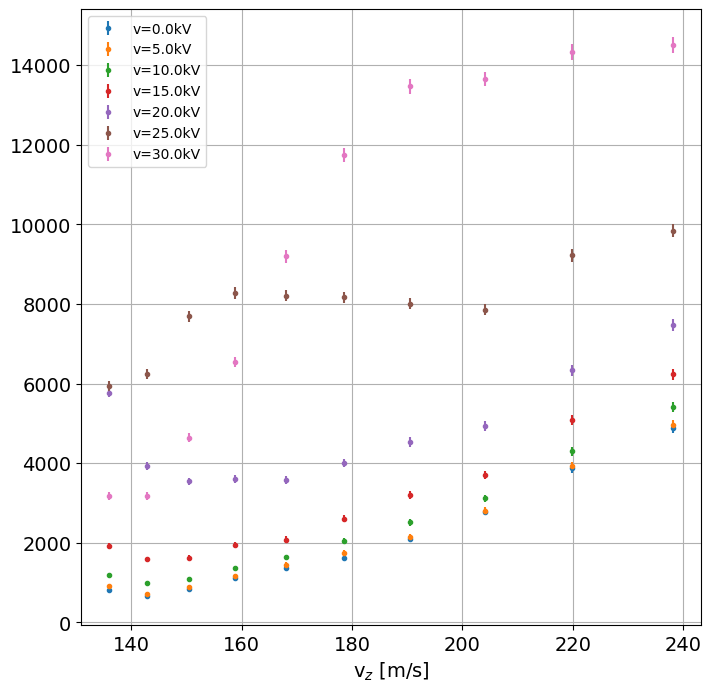

In [527]:

fig, ax = plt.subplots(figsize=(8,8))
hist_dict = {}
for voltage, data in results_scan.items():
    hists = []
    hists_err = []
    if data['mF=0'] is None:
        continue
    for mF in data.keys():
        vzs = data[mF].scan_values[2]
        n_photons = data[mF].results
        hs, _ = np.histogram(vzs, bins=bins, weights=n_photons)
        if len(hists) == 0:
            hists = hs
            hists_err = np.sqrt(hs)
        else:
            for i, h in enumerate(hs):
                hists[i] = np.array(hists[i]) + np.array(h)
                hists_err[i] = np.array(hists_err[i]) + np.array(np.sqrt(h))
        hist_dict[voltage] = (hists, hists_err)

    ax.errorbar(bin_centers, hists, yerr=hists_err, fmt=".", label=f"v={voltage/1000}kV")
ax.set_xlabel("v$_z$ [m/s]")
# ax.set_yscale('log')
ax.legend(ncols=1, prop={'size': 10})
ax.grid(True)

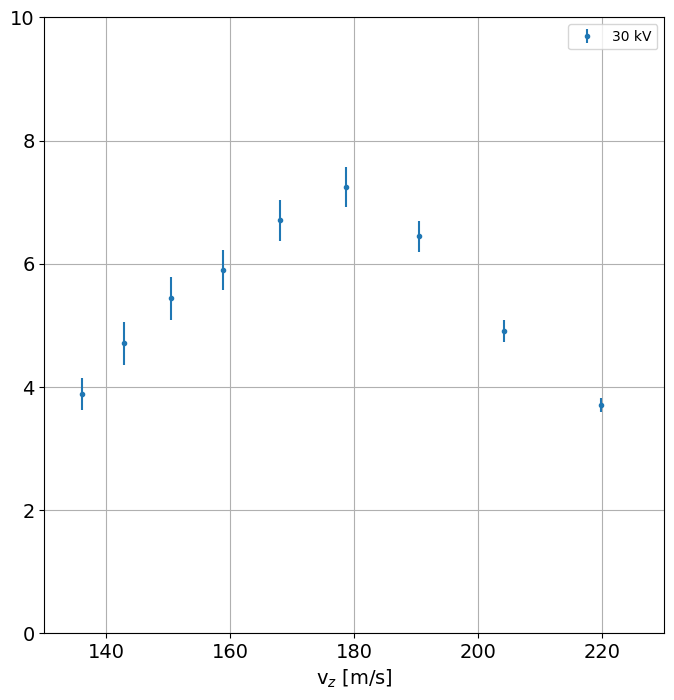

In [528]:
def division_error_propagation(a,sa,b,sb):
    return a/b * np.sqrt((sa/a)**2+(sb/b)**2)


fig, ax = plt.subplots(figsize=(8,8))


ax.errorbar(bin_centers, hist_dict[30000][0]/hist_dict[0][0], yerr=division_error_propagation(hist_dict[30000][0], hist_dict[30000][1], hist_dict[0][0], hist_dict[0][1]), fmt=".", label=f'{30} kV')
ax.set_xlim(130,230)
ax.set_ylim(0,10)
ax.set_xlabel("v$_z$ [m/s]")
ax.legend(ncols=2, prop={'size': 10})
ax.grid(True)

In [518]:
hist_dict[30000][0]/hist_dict[0][0]

array([3.88321096, 4.71010348, 5.44295333, 5.89849022, 6.70683954,
       7.25012865, 6.44363378, 4.91277707, 3.70305924, 2.96902024])

In [519]:
division_error_propagation(hist_dict[30000][0], hist_dict[30000][1], hist_dict[0][0], hist_dict[0][1])

array([0.26399529, 0.34545734, 0.34960983, 0.32888509, 0.33269053,
       0.32884805, 0.25909422, 0.17456954, 0.11472131, 0.08419681])

In [520]:
signal_err_summed 

array([0.04976664, 0.05003429, 0.05282587, 0.0613641 , 0.0817018 ,
       0.13205254, 0.21175621])

## Gain vs Voltage

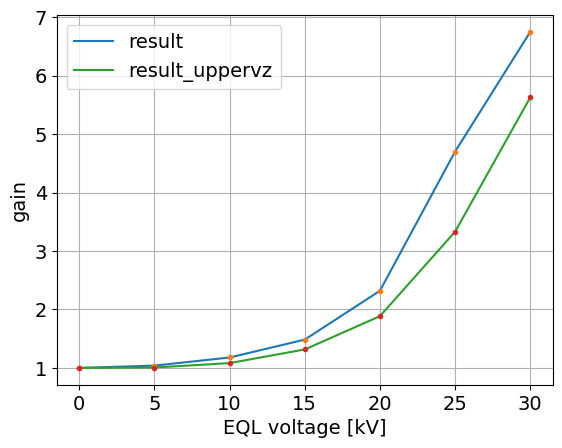

In [521]:
fig, ax = plt.subplots()
for name in ["", "_uppervz" , "_lowervz"]:
    with open("results_scan"+name+".pkl", "rb") as f:
        results_scan = pickle.load(f)
    signal = []
    voltages = []
    signal_err = []
    for v, res in results_scan.items():
        for mF in res.keys():
            if res[mF] is None:
                break

            if len(voltages) == 0:
                voltages.append(v)
            if voltages[-1] != v:
                voltages.append(v)

            signal.append(res[mF].results.sum() * pop_mapping[mF])
            signal_err.append(np.sqrt(res[mF].results.sum()) * pop_mapping[mF])
    voltages = np.array(voltages)
    signal = np.array(signal).reshape(-1, 3).sum(axis=1)
    signal_err_reshaped = np.array(signal_err).reshape(-1, 3)
    # Sum along the mFs
    signal_err_summed = signal_err_reshaped.sum(axis=1)
    signal_err_summed = division_error_propagation(signal, signal_err_summed, signal[0], signal_err_summed[0])

    
    ax.plot(voltages / 1e3, signal / signal[0], label="result"+name)

    ax.plot(voltages / 1e3, signal / signal[0], ".")
    if name=="_uppervz":
        break
ax.set_xlabel("EQL voltage [kV]")
ax.set_ylabel("gain")
ax.legend()
ax.grid()


In [522]:
signal

array([ 5658.99395903,  5699.46658083,  6126.06923064,  7446.22805539,
       10668.98664355, 18843.91103219, 31844.35588037])

In [506]:
signal_err_summed

array([0.04976664, 0.05003429, 0.05282587, 0.0613641 , 0.0817018 ,
       0.13205254, 0.21175621])

In [523]:
signal / signal[0]

array([1.        , 1.00715191, 1.0825368 , 1.31582188, 1.88531508,
       3.32990478, 5.6272115 ])

In [285]:
fwhm = 2 * np.sqrt(2 * np.log(2)) * odepars.σz
waist = np.sqrt(2) * fwhm / (2 * np.sqrt(np.log(2)))

peak_intensity = 2 * power / (np.pi * waist**2)

peak_intensity


2292.0106971280175